In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
df = pd.read_pickle("../data/clean_data/LoL_full_data_filtered.pkl")

data = df.TXT.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['disturbance', 'legacies', 'and', 'climate', 'jointly', 'drive', 'tree', 'growth', 'and', 'mortality', 'in', 'an', 'intensively', 'studied', 'boreal', 'forest', 'boreal', 'forest', 'carbon', 'cycling', 'climate', 'change', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine', 'learning', 'most', 'north', 'american', 'forests', 'are', 'at', 'some', 'stage', 'of', 'post', 'disturbance', 'regrowth', 'subject', 'to', 'changing', 'climate', 'and', 'exhibit', 'growth', 'and', 'mortality', 'patterns', 'that', 'may', 'not', 'be', 'closely', 'coupled', 'to', 'annual', 'environmental', 'conditions', 'distinguishing', 'the', 'possibly', 'interacting', 'effects', 'of', 'these', 'processes', 'is', 'necessary', 'to', 'put', 'short', 'term', 'studies', 'in', 'longer', 'term', 'context', 'and', 'particularly', 'important', 'for', 'the', 'carbon', 'dense', 'fire', 'prone', 'boreal', 'forest', 'the', 'goals', 'of', 'this', 'study', 'were', 'to', 'combine', 'sampling', 'inventory', 'records', 

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['disturbance', 'legacies', 'and', 'climate', 'jointly', 'drive', 'tree_growth', 'and', 'mortality', 'in', 'an', 'intensively', 'studied', 'boreal_forest', 'boreal_forest', 'carbon', 'cycling', 'climate_change', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine_learning', 'most', 'north', 'american', 'forests', 'are', 'at', 'some', 'stage', 'of', 'post', 'disturbance', 'regrowth', 'subject', 'to', 'changing_climate', 'and', 'exhibit', 'growth', 'and', 'mortality', 'patterns', 'that', 'may_not', 'be', 'closely', 'coupled', 'to', 'annual', 'environmental', 'conditions', 'distinguishing', 'the', 'possibly', 'interacting', 'effects', 'of', 'these', 'processes', 'is_necessary', 'to', 'put', 'short_term', 'studies', 'in', 'longer', 'term', 'context', 'and', 'particularly', 'important', 'for', 'the', 'carbon', 'dense', 'fire', 'prone', 'boreal_forest', 'the', 'goals', 'of', 'this_study', 'were', 'to', 'combine', 'sampling', 'inventory', 'records', 'and', 'machine_learning_algorithm

In [262]:
### NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# spacy stopwords
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
print(len(all_stopwords))
all_stopwords.update(["use","uses", "used" "model", "models", "system","systems", "base","based","bases" "high", "index","approach", 
                      "information", "datum", "basis", "process", "tool","new", "problem", "result", "results", "ressource", 
                      "method", "image", "study", "feature", "technique", "different", "test", "low", "low", "class", "analysis", 
                      "paper", "provide", "provides", "provided", "data", "increase", "increases", "increased", "propose", "proposes",
                     "proposed", "feature", "features", "big", "level", 'object', "levels", "objects", "method","methods",
                     "modelled", "modeled", "modelling", "modeling", "large", "case", "cases", "present", "presents", "consider",
                     "considering", "considered", "prediction", "predicts", "predict", "predicted", "compare", "compares", "compared",
                     "comparing", "improve", "improves", "improving", "improved", "estimate", "estimating", "estimates", "estimated", 
                     "network", "networks", "control", "controls", "controlled", "controlling"])
print(len(all_stopwords))

406
412


In [263]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [264]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['disturbance', 'legacy', 'climate', 'jointly', 'drive', 'mortality', 'intensively', 'study', 'carbon', 'cycling', 'dendrology', 'disturbance', 'forest', 'mortality', 'machine_learne', 'north', 'american', 'forest', 'stage', 'post', 'disturbance', 'regrowth', 'subject', 'changing_climate', 'exhibit', 'growth', 'mortality', 'pattern', 'closely', 'couple', 'annual', 'environmental', 'condition', 'distinguish', 'possibly', 'interact', 'effect', 'process', 'necessary', 'study', 'long', 'term', 'context', 'particularly', 'important', 'carbon', 'dense', 'fire', 'boreal_for', 'goal', 'combine', 'sample', 'inventory', 'record', 'understand', 'death', 'change', 'highly', 'study', 'site', 'northern', 'old', 'black', 'spruce', 'central', 'inventory', 'period', 'stand', 'density', 'decline', 'significantly', 'tree', 'mortality', 'average', 'mortality', 'occur', 'medium', 'sized', 'tree', 'recruitment', 'minimal', 'probably', 'significant', 'influx', 'tree', 'stand', 'initiation', 'recent_decade',

In [265]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 3), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 4), (32, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 2), (40, 2), (41, 3), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 7), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 4), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 3), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [266]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('air', 1),
  ('american', 1),
  ('annual', 1),
  ('average', 1),
  ('black', 1),
  ('boreal_for', 1),
  ('capability', 1),
  ('carbon', 2),
  ('carbon_sequestration', 1),
  ('central', 1),
  ('change', 1),
  ('changing_climate', 2),
  ('chronology', 1),
  ('climate', 3),
  ('closely', 1),
  ('combine', 2),
  ('condition', 1),
  ('construct', 1),
  ('context', 1),
  ('couple', 1),
  ('current', 2),
  ('cycling', 1),
  ('death', 1),
  ('decadal', 1),
  ('decline', 1),
  ('dendrology', 1),
  ('dense', 1),
  ('density', 1),
  ('depressed', 1),
  ('depression', 1),
  ('distinguish', 1),
  ('disturbance', 4),
  ('drive', 1),
  ('dynamic', 1),
  ('effect', 2),
  ('environmental', 1),
  ('exert', 2),
  ('exhibit', 1),
  ('explain', 1),
  ('extreme', 2),
  ('fire', 2),
  ('forest', 3),
  ('forest_structure', 1),
  ('goal', 1),
  ('growth', 3),
  ('higher', 1),
  ('highly', 1),
  ('implication', 1),
  ('important', 1),
  ('influence', 1),
  ('influx', 1),
  ('initiation', 1),
  ('intensively'

In [267]:
from collections import Counter

frequencies = Counter()
frequencies_ngram = Counter()
stuff = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
for i, tok in enumerate(stuff):
    for tup in tok:
        if "_" in tup[0]:
            frequencies_ngram[tup[0]] += 1
        frequencies[tup[0]] +=1


print(frequencies.most_common(10))
print(frequencies["neural_network"])

[('area', 390), ('develop', 318), ('management', 300), ('sustainable', 257), ('important', 248), ('environmental', 246), ('show', 246), ('include', 236), ('classification', 235), ('accuracy', 234)]
0


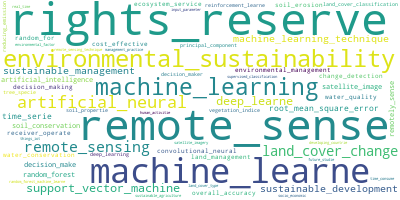

In [268]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies_ngram)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

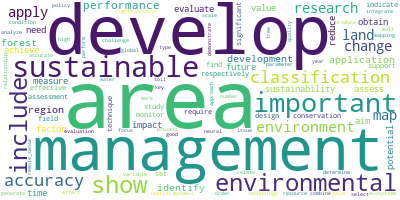

In [269]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

In [270]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [271]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = list(row)[0]
        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5791,"area, land, forest, classification, change, ma...",Disturbance legacies and climate jointly drive...
1,1,0.0,0.9944,"area, land, forest, classification, change, ma...",Mapping individual tree health using full-wave...
2,2,0.0,0.4943,"area, land, forest, classification, change, ma...","Innovative Use of Sensors to Collect, Analyze ..."
3,3,0.0,0.5248,"area, land, forest, classification, change, ma...","Do changes in spatial distribution, structure ..."
4,4,3.0,0.9334,"soil, performance, water, groundwater, ensembl...",Ensemble Wavelet-Support Vector Machine Approa...
...,...,...,...,...,...
1049,1049,3.0,0.6061,"soil, performance, water, groundwater, ensembl...",Combining CityGML files and data-driven models...
1050,1050,0.0,0.5251,"area, land, forest, classification, change, ma...",Machine Learning for Gully Feature Extraction ...
1051,1051,0.0,0.9879,"area, land, forest, classification, change, ma...",Scenarios of land use and land cover change fo...
1052,1052,0.0,0.9316,"area, land, forest, classification, change, ma...",Update and spatial extension of strategic fore...


In [272]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"area" + 0.014*"land" + 0.010*"forest" + 0.010*"classification" + '
  '0.009*"change" + 0.009*"map" + 0.006*"region" + 0.006*"management" + '
  '0.005*"spatial" + 0.004*"mapping"'),
 (1,
  '0.009*"sustainable" + 0.008*"sustainability" + 0.007*"design" + '
  '0.007*"environment" + 0.007*"technology" + 0.007*"research" + '
  '0.006*"application" + 0.006*"development" + 0.006*"environmental" + '
  '0.005*"energy"'),
 (2,
  '0.013*"detection" + 0.010*"crop" + 0.008*"tree" + 0.007*"image" + '
  '0.007*"end" + 0.007*"stand" + 0.006*"agricultural" + 0.006*"yield" + '
  '0.005*"succession" + 0.005*"reduce"'),
 (3,
  '0.022*"soil" + 0.009*"performance" + 0.009*"water" + 0.006*"groundwater" + '
  '0.006*"ensemble" + 0.006*"show" + 0.006*"accuracy" + 0.005*"predict" + '
  '0.005*"regression" + 0.005*"value"')]


In [273]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorted = sent_topics_sorted.set_index("Topic_Num")
# Show
sent_topics_sorted.head(8)

,Topic_Perc_Contrib,Keywords,Text
Topic_Num,,,
0.0,0.9948,"area, land, forest, classification, change, ma...",Multiscale spatial planning to maintain forest...
1.0,0.9922,"sustainable, sustainability, design, environme...",A self-aware paradigm for autonomous architect...
2.0,0.8174,"detection, crop, tree, image, end, stand, agri...",Towards an Autonomous Vision-Based Unmanned Ae...
3.0,0.9766,"soil, performance, water, groundwater, ensembl...",Modelling of infiltration of sandy soil using ...


In [274]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.913331222038582

Coherence Score:  0.40339320201478746


In [276]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, '../html/4topics_LOL.html')
vis

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.100857 -0.022801       1        1  44.331937
1     -0.066809 -0.184523       2        1  29.667877
3     -0.083575  0.199260       3        1  16.840957
2      0.251241  0.008063       4        1   9.159228, topic_info=                Term        Freq       Total Category  logprob  loglift
835             soil  407.000000  407.000000  Default  30.0000  30.0000
1064            land  651.000000  651.000000  Default  29.0000  29.0000
132             area  797.000000  797.000000  Default  28.0000  28.0000
139   classification  475.000000  475.000000  Default  27.0000  27.0000
10            change  438.000000  438.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2412        wildlife   32.338370   62.143286   Topic4  -5.7239   1.7372
464       monitoring   44.485672  179.275679   Topic4  -5.4050   0.9967
16         condition   44.755950  189.764945   Topic4  -5.3989   0.9458
276       production   30.308559  149.569735   Topic4  -5.7887   0.7941
706           damage   28.605098   56.268954   Topic4  -5.8466   1.7139

[266 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3897      1  0.024301  abandonment
3897      4  0.972037  abandonment
992       1  0.581691     accuracy
992       3  0.350337     accuracy
992       4  0.069406     accuracy
...     ...       ...          ...
120       3  0.012341         year
120       4  0.061705         year
1201      1  0.079854        yield
1201      3  0.515418        yield
1201      4  0.399268        yield

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [189]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts*100/topic_counts.sum(), 4)
topic_counts

sent_topics_sorted = sent_topics_sorted.merge(topic_counts, how = "left", left_index=True, right_index = True)
sent_topics_sorted = sent_topics_sorted.merge(topic_contribution, how = "left", left_index = True, right_index = True)
sent_topics_sorted = sent_topics_sorted.rename(columns={"Dominant_Topic_x": "Articles", "Dominant_Topic_y": "Percentage"})
sent_topics_sorted

,Topic_Perc_Contrib,Keywords,Text,Articles,Percentage
Topic_Num,,,,,
0.0,0.9415,"conservation, forest, ecosystem, change, lands...","Do changes in spatial distribution, structure ...",118,11.1954
1.0,0.8153,"technology, control, environment, network, ene...",Application of neural network to building envi...,134,12.7135
2.0,0.9515,"soil, prediction, predict, performance, water,...",Neuro-fuzzy ensemble techniques for the predic...,224,21.2524
3.0,0.7205,"temperature, drought, response, plant, time, c...",A Re-elicitation Assay to Correlate flg22-Sign...,24,2.2770
4.0,0.9368,"land, research, sustainability, sustainable, e...",TOWARDS AN UNDERSTANDING OF LAND CONSUMPTION I...,325,30.8349
5.0,0.8986,"classification, map, area, forest, image, tree...",On the use of binary partition trees for the t...,229,21.7268


In [168]:
for i,j in sent_topics_sorted.Keywords.items():
    print(i,j)

0.0 detection, stock, uncertainty, monitoring, response, firm, wildlife, plant, protection, animal
1.0 building, intelligent, energy, control, end, network, smart, technology, security, sensor
2.0 soil, prediction, crop, predict, yield, performance, ensemble, depth, content, optimization
3.0 prediction, predict, temperature, water, hybrid, rainfall, groundwater, drought, forecast, simulation
4.0 land, urban, policy, development, scenario, plan, agricultural, area, sustainable, rate
5.0 classification, accuracy, image, method, object, compare, mapping, estimation, estimate, accurate
6.0 area, forest, map, change, region, land, conservation, assess, landscape, management
7.0 research, sustainability, sustainable, design, environmental, environment, application, present, management, framework


In [277]:
dic_of_topic = {0:"Lands and Forests", 1:"Sustainable energies", 2:"Water and soils", 3:"Agriculture"}
df_dominant_topic["Topic"] = df_dominant_topic["Dominant_Topic"].apply(lambda x: dic_of_topic[x])
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic
0,0,0.0,0.5791,"area, land, forest, classification, change, ma...",Disturbance legacies and climate jointly drive...,Lands and Forests
1,1,0.0,0.9944,"area, land, forest, classification, change, ma...",Mapping individual tree health using full-wave...,Lands and Forests
2,2,0.0,0.4943,"area, land, forest, classification, change, ma...","Innovative Use of Sensors to Collect, Analyze ...",Lands and Forests
3,3,0.0,0.5248,"area, land, forest, classification, change, ma...","Do changes in spatial distribution, structure ...",Lands and Forests
4,4,3.0,0.9334,"soil, performance, water, groundwater, ensembl...",Ensemble Wavelet-Support Vector Machine Approa...,Agriculture
...,...,...,...,...,...,...
1049,1049,3.0,0.6061,"soil, performance, water, groundwater, ensembl...",Combining CityGML files and data-driven models...,Agriculture
1050,1050,0.0,0.5251,"area, land, forest, classification, change, ma...",Machine Learning for Gully Feature Extraction ...,Lands and Forests
1051,1051,0.0,0.9879,"area, land, forest, classification, change, ma...",Scenarios of land use and land cover change fo...,Lands and Forests
1052,1052,0.0,0.9316,"area, land, forest, classification, change, ma...",Update and spatial extension of strategic fore...,Lands and Forests


In [278]:
result = pd.concat([df.reset_index(drop=True), df_dominant_topic.Dominant_Topic,df_dominant_topic.Topic,  df_dominant_topic.Keywords], axis=1)
result


,PT,AU,TI,LA,DE,AB,C1,PY,CN,TXT,Dominant_Topic,Topic,Keywords
0,J,"Bond-Lamberty, B; Rocha, AV; Calvin, K; Holmes...",Disturbance legacies and climate jointly drive...,English,boreal forest; carbon cycling; climate change;...,Most North American forests are at some stage ...,"[Bond-Lamberty, Ben; Calvin, Katherine] Univ M...",2014.0,"[United States, United States, United States, ...",Disturbance legacies and climate jointly drive...,0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
1,J,"Shendryk, I; Broich, M; Tulbure, MG; McGrath, ...",Mapping individual tree health using full-wave...,English,Tree health; Airborne laser scanning; Imaging ...,Declining forest health can affect crucial eco...,"[Shendryk, Iurii; Broich, Mark; Tulbure, Mirel...",2016.0,"[Australia, Australia, Australia, Australia, A...",Mapping individual tree health using full-wave...,0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
2,C,"Iakovoglou, V; Zaimes, GN; Emmanouloudis, D; I...","Innovative Use of Sensors to Collect, Analyze ...",English,sustainable agriculture; vineyards; Greece; st...,The main goal of all agricultural systems is t...,"[Iakovoglou, V.; Zaimes, G. N.; Emmanouloudis,...",2014.0,"[Greece, Greece, Greece]","Innovative Use of Sensors to Collect, Analyze ...",0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
3,J,"Ficko, A; Poljanec, A; Boncina, A","Do changes in spatial distribution, structure ...",English,Abies alba; Decline; Spatiotemporal dynamics; ...,Silver fir decline was investigated based on c...,"[Ficko, Andrej; Poljanec, Ales; Boncina, Andre...",2011.0,[Slovenia],"Do changes in spatial distribution, structure ...",0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
4,J,"Himanshu, SK; Pandey, A; Yadav, B",Ensemble Wavelet-Support Vector Machine Approa...,English,Support vector machine (SVM); Support vector m...,Explicit prediction of the suspended sediment ...,"[Himanshu, Sushil Kumar; Pandey, Ashish] India...",2017.0,"[India, India]",Ensemble Wavelet-Support Vector Machine Approa...,3.0,Agriculture,"soil, performance, water, groundwater, ensembl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,J,"Chen, SS; Zhang, W; Wong, NH; Ignatius, M",Combining CityGML files and data-driven models...,English,CityGML; Data-driven model; Outdoor air temper...,This research first developed a solution to co...,"[Chen, Shisheng; Zhang, Wen; Wong, Nyuk Hien; ...",2020.0,[Singapore],Combining CityGML files and data-driven models...,3.0,Agriculture,"soil, performance, water, groundwater, ensembl..."
1050,J,"Phinzi, K; Abriha, D; Bertalan, L; Holb, I; Sz...",Machine Learning for Gully Feature Extraction ...,English,linear discriminant analysis; random forest; s...,Gullies reduce both the quality and quantity o...,"[Phinzi, Kwanele; Abriha, David] Univ Debrecen...",2020.0,"[Hungary, Hungary, Hungary]",Machine Learning for Gully Feature Extraction ...,0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
1051,J,"Armenteras, D; Murcia, U; Gonzalez, TM; Baron,...",Scenarios of land use and land cover change fo...,English,Land use land cover; Forest loss; Amazonia; Co...,Changes in land use and land cover (LULC) are ...,"[Armenteras, Dolors; Marisol Gonzalez, Tania] ...",2019.0,"[Colombia, Colombia]",Scenarios of land use and land cover change fo...,0.0,Lands and Forests,"area, land, forest, classification, change, ma..."
1052,J,"Shang, C; Coops, NC; Wulder, MA; White, JC; He...",Update and spatial extension of strategic fore...,English,Species; Biomass; Volume; Land cover; Monitori...,Up-to-date forest inventory information relati...,"[Shang, Chen; Coops, Nicholas C.] Univ British...",2020.0,"[Canada, Canada]",Update and spatial extension of strategic fore...,0.0,Lands and Forests,"area, land, forest, classification, change, ma..."


In [279]:
year_topic = result.groupby(["PY", "Topic"]).size()
year_topic = year_topic.unstack(1)
year_topic


Topic,Agriculture,Lands and Forests,Sustainable energies,Water and soils
PY,,,,
2010.0,2,15,10,1
2011.0,7,19,11,3
2012.0,7,18,5,2
2013.0,11,18,8,1
2014.0,4,24,11,2
2015.0,15,33,22,3
2016.0,15,27,21,4
2017.0,16,36,33,3
2018.0,23,74,41,6


<AxesSubplot:title={'center':'Life on Land over the years, four topics'}, xlabel='PY'>

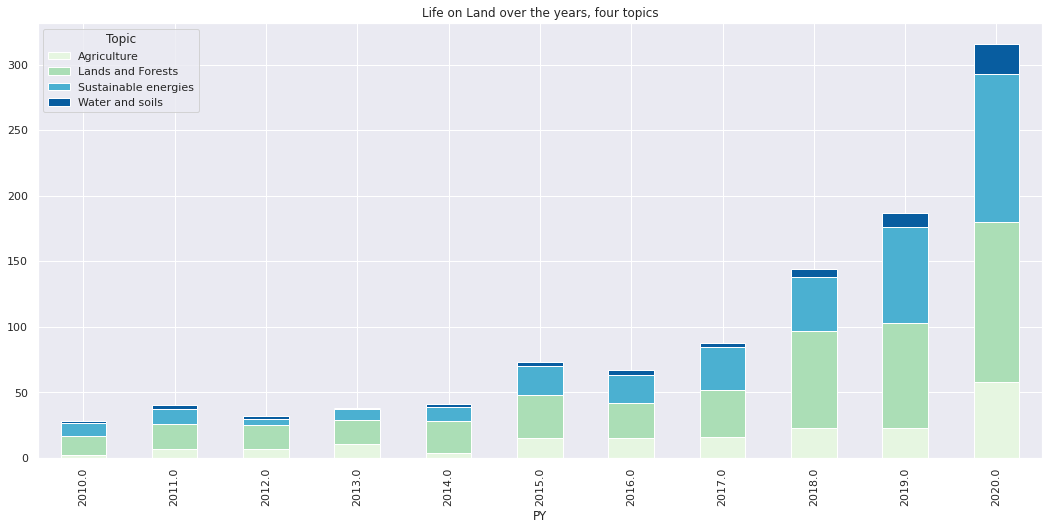

In [284]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()
gr = year_topic.transpose().T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set_title("Life on Land over the years, four topics")
gr.figure.savefig("../img/LoL_4topics.png")
gr

In [285]:
year_topic_percentage = result.groupby(['PY']).Topic.value_counts(normalize=True).mul(100).unstack(1).transpose()
year_topic_percentage

PY,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Topic,,,,,,,,,,,
Agriculture,7.142857,17.5,21.875,28.947368,9.756098,20.547945,22.388060,18.181818,15.972222,12.299465,18.354430
Lands and Forests,53.571429,47.5,56.250,47.368421,58.536585,45.205479,40.298507,40.909091,51.388889,42.780749,38.607595
Sustainable energies,35.714286,27.5,15.625,21.052632,26.829268,30.136986,31.343284,37.500000,28.472222,39.037433,35.759494
Water and soils,3.571429,7.5,6.250,2.631579,4.878049,4.109589,5.970149,3.409091,4.166667,5.882353,7.278481


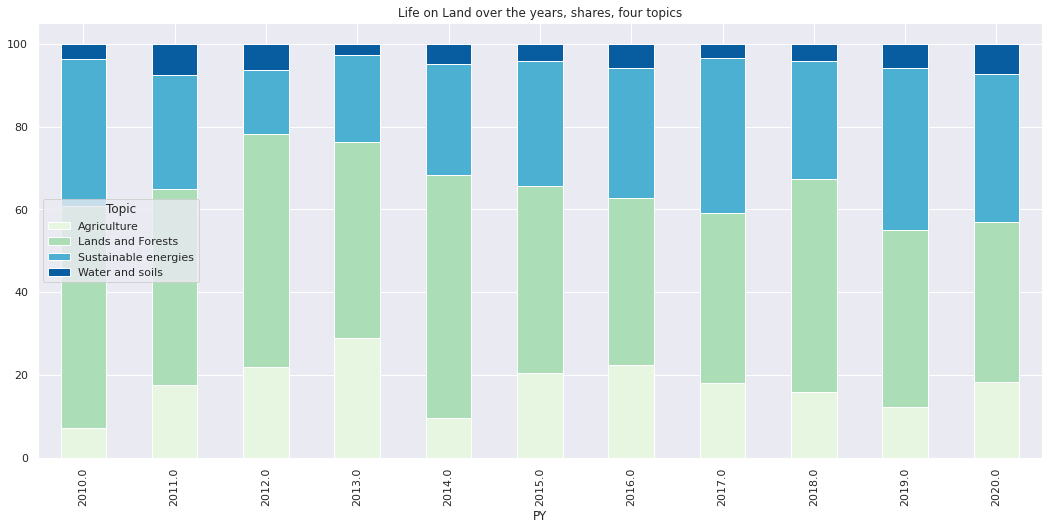

In [323]:
gr = year_topic_percentage.T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set(title="Life on Land over the years, shares, four topics")
gr.figure.savefig("../img/LoL_4topics_share.png")

In [293]:
# Average sentiment analysis for each topic
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /home/kevin-
[nltk_data]     main/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [290]:
result['sentiment_score'] = result.TXT.apply(lambda x : sid.polarity_scores(x))
result["neg_score"] = result.sentiment_score.apply(lambda x : x['neg'])
result["neu_score"] = result.sentiment_score.apply(lambda x : x['neu'])
result["pos_score"] = result.sentiment_score.apply(lambda x : x['pos'])
result["compound_score"] = result.sentiment_score.apply(lambda x : x['compound'])

In [325]:
for ind, row in result.iterrows():
    if abs(row.compound_score) > 0.994:
        print(ind, row.TI) 
        print("Negative score: ",row.neg_score, " Positive score: ", row.pos_score, " Compound score: ", row.compound_score)
        print("Topic : ", row.Topic)
        print("---")
        print(row.AB)
        print('\n')

71 The Pilot Environmental Performance Index 2006 as a Tool for Optimising Environmental Sustainability at the Country Level
Negative score:  0.008  Positive score:  0.19  Compound score:  0.9985
Topic :  Sustainable energies
---
The Environmental Performance Index (EPI) constitutes one of the most influential as well as prevalent measures of environmental sustainability (ES) currently in use. In this piece of research, the earliest version of the EPI 2006 (the Pilot EPI) is employed for (a) uncovering the characteristics of the maximally sustainable country, and (b) assisting any interested country (either participating in the creation of the Pilot EPI, or not) on how to maximally increase its ES. A genetic algorithm (GA) is employed to this end, where (i) each of the three constructs of the Pilot EPI hierarchy (raw data, Proximity-to-Target data, and Policy Categories), (ii) the Pilot EPI scores, and (iii) the underlying relationship between (i) and (ii), are encoded in the (I) chrom

In [315]:
result

,PT,AU,TI,LA,DE,AB,C1,PY,CN,TXT,Dominant_Topic,Topic,Keywords,sentiment_score,neg_score,neu_score,pos_score,compound_score
0,J,"Bond-Lamberty, B; Rocha, AV; Calvin, K; Holmes...",Disturbance legacies and climate jointly drive...,English,boreal forest; carbon cycling; climate change;...,Most North American forests are at some stage ...,"[Bond-Lamberty, Ben; Calvin, Katherine] Univ M...",2014.0,"[United States, United States, United States, ...",Disturbance legacies and climate jointly drive...,0.0,Lands and Forests,"area, land, forest, classification, change, ma...","{'neg': 0.087, 'neu': 0.803, 'pos': 0.11, 'com...",0.087,0.803,0.110,0.7308
1,J,"Shendryk, I; Broich, M; Tulbure, MG; McGrath, ...",Mapping individual tree health using full-wave...,English,Tree health; Airborne laser scanning; Imaging ...,Declining forest health can affect crucial eco...,"[Shendryk, Iurii; Broich, Mark; Tulbure, Mirel...",2016.0,"[Australia, Australia, Australia, Australia, A...",Mapping individual tree health using full-wave...,0.0,Lands and Forests,"area, land, forest, classification, change, ma...","{'neg': 0.038, 'neu': 0.932, 'pos': 0.031, 'co...",0.038,0.932,0.031,-0.6815
2,C,"Iakovoglou, V; Zaimes, GN; Emmanouloudis, D; I...","Innovative Use of Sensors to Collect, Analyze ...",English,sustainable agriculture; vineyards; Greece; st...,The main goal of all agricultural systems is t...,"[Iakovoglou, V.; Zaimes, G. N.; Emmanouloudis,...",2014.0,"[Greece, Greece, Greece]","Innovative Use of Sensors to Collect, Analyze ...",0.0,Lands and Forests,"area, land, forest, classification, change, ma...","{'neg': 0.008, 'neu': 0.857, 'pos': 0.135, 'co...",0.008,0.857,0.135,0.9939
3,J,"Ficko, A; Poljanec, A; Boncina, A","Do changes in spatial distribution, structure ...",English,Abies alba; Decline; Spatiotemporal dynamics; ...,Silver fir decline was investigated based on c...,"[Ficko, Andrej; Poljanec, Ales; Boncina, Andre...",2011.0,[Slovenia],"Do changes in spatial distribution, structure ...",0.0,Lands and Forests,"area, land, forest, classification, change, ma...","{'neg': 0.011, 'neu': 0.885, 'pos': 0.105, 'co...",0.011,0.885,0.105,0.9821
4,J,"Himanshu, SK; Pandey, A; Yadav, B",Ensemble Wavelet-Support Vector Machine Approa...,English,Support vector machine (SVM); Support vector m...,Explicit prediction of the suspended sediment ...,"[Himanshu, Sushil Kumar; Pandey, Ashish] India...",2017.0,"[India, India]",Ensemble Wavelet-Support Vector Machine Approa...,3.0,Agriculture,"soil, performance, water, groundwater, ensembl...","{'neg': 0.051, 'neu': 0.844, 'pos': 0.106, 'co...",0.051,0.844,0.106,0.9783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,J,"Chen, SS; Zhang, W; Wong, NH; Ignatius, M",Combining CityGML files and data-driven models...,English,CityGML; Data-driven model; Outdoor air temper...,This research first developed a solution to co...,"[Chen, Shisheng; Zhang, Wen; Wong, Nyuk Hien; ...",2020.0,[Singapore],Combining CityGML files and data-driven models...,3.0,Agriculture,"soil, performance, water, groundwater, ensembl...","{'neg': 0.025, 'neu': 0.919, 'pos': 0.055, 'co...",0.025,0.919,0.055,0.7925
1050,J,"Phinzi, K; Abriha, D; Bertalan, L; Holb, I; Sz...",Machine Learning for Gully Feature Extraction ...,English,linear discriminant analysis; random forest; s...,Gullies reduce both the quality and quantity o...,"[Phinzi, Kwanele; Abriha, David] Univ Debrecen...",2020.0,"[Hungary, Hungary, Hungary]",Machine Learning for Gully Feature Extraction ...,0.0,Lands and Forests,"area, land, forest, classification, change, ma...","{'neg': 0.034, 'neu': 0.901, 'pos': 0.065, 'co...",0.034,0.901,0.065,0.7906
1051,J,"Armenteras, D; Murcia, U; Gonzalez, TM; Baron,...",Scenarios of land use and land cover change fo...,English,Land use land cover; Forest loss; Amazonia; Co...,Changes in land use and land cover (LULC) are ...,"[Armenteras, Dolors; Marisol Gonzalez, Tania] ...",2019.0,"[Colombia, Colombia]",Scenarios of land us

In [322]:
res = result.groupby("Topic")
res.compound_score.mean()


Topic
Agriculture             0.707684
Lands and Forests       0.600050
Sustainable energies    0.772507
Water and soils         0.635714
Name: compound_score, dtype: float64

<AxesSubplot:xlabel='Topic'>

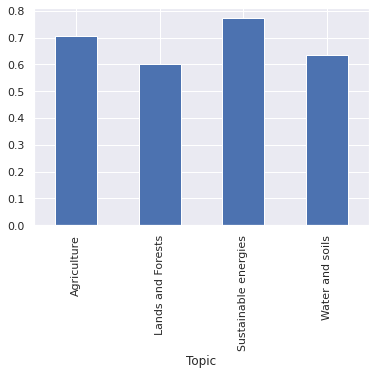

In [328]:
res.compound_score.mean().plot.bar()